# RAG System for Enhanced PDF Data Extraction and Question-Answering

**Objective:**
Develop a Retrieval-Augmented Generation (RAG) system that processes and extracts key data from PDF documents, allowing for efficient question-answering and information retrieval. This project integrates NVIDIA and OPENAI models to explore two distinct approaches for a RAG system, enhancing functionality for more robust response generation.

**Project Steps:**

*   **Data Parsing with LlamaParse:**
Begin with document parsing using LlamaParse along with specific parsing_instructions to accurately extract text, images, tables, and any other relevant content from PDF files.
*   **Custom Prompting with PromptTemplate:**
Create and implement a custom PromptTemplate to structure prompts effectively for document-related questions and follow-up responses, improving model precision.
*   **Dual RAG System Construction:**
Develop two separate RAG systems—one with NVIDIA models and the other with OPENAI models.
*   **Enhanced Retrieval with Reranker Models:**
Integrate a reranker in both the NVIDIA and OPENAI systems to prioritize and re-evaluate the relevance of retrieved responses, leading to higher accuracy in information retrieval.

In [1]:
!pip -q install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.5 MB/s eta 0:00:00


In [2]:
!pip -q install "pydantic<2"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 35.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.4.15 requires pydantic>=2.7.0, but you have pydantic 1.10.18 which is incompatible.


In [3]:
!pip -q install llama-index-core==0.10.50
!pip -q install llama-index-readers-file==0.1.25
!pip -q install llama-index-llms-nvidia==0.1.3
!pip -q install llama-index-embeddings-nvidia==0.1.4
!pip -q install llama-index-postprocessor-nvidia-rerank==0.1.2
!pip -q install ipywidgets==8.1.3
!pip -q install llama-parse==0.4.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.0 MB/s eta 0:00:00


In [4]:
import os
import nest_asyncio
import subprocess
from typing import List
import json
from IPython.display import display, Markdown
from llama_parse import LlamaParse
from llama_index.core.schema import TextNode
from llama_index.core import VectorStoreIndex, Settings, PromptTemplate
from llama_index.embeddings.nvidia import NVIDIAEmbedding
from llama_index.llms.nvidia import NVIDIA
from llama_index.postprocessor.nvidia_rerank import NVIDIARerank

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /usr/local/lib/python3.10/dist-
[nltk_data]     packages/llama_index/core/_static/nltk_cache...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [5]:
nest_asyncio.apply()

with open(os.devnull, 'w') as devnull:
    subprocess.run([
        "wget", "-O", "guide.pdf",
        "https://www.dropbox.com/scl/fi/n7wl6dz6rmr1fq12umqtm/kyiv-guide.pdf?rlkey=yb0e1vfxfbm77h2u33v2lnjtc&st=z16ddb9n&dl=1"
    ], stdout=devnull, stderr=devnull)

In [6]:
os.environ["LLAMA_CLOUD_API_KEY"] = "llx-..."
os.environ["OPENAI_API_KEY"] = "sk-proj-..."
os.environ["NVIDIA_API_KEY"] = "nvapi-..."
os.environ["COHERE_API_KEY"] = "..."

In [7]:
def get_text_nodes(json_list: List[dict]):
    """
    Converts a list of JSON objects into a list of TextNode objects, each containing text
    and metadata for a page.

    Parameters:
    json_list: List[dict]
        A list of dictionaries where each dictionary represents a page, containing the
        text in Markdown format under "md" and the page number under "page".

    Returns:
    List[TextNode]
        A list of TextNode objects, each with the page's text and metadata.
    """
    text_nodes = []
    for idx, page in enumerate(json_list):
        text_node = TextNode(text=page["md"], metadata={"page": page["page"]})
        text_nodes.append(text_node)
    return text_nodes

### Using LLamaParse

Since our document serves as a guide to Kyiv and includes a variety of information, these instructions were created to improve readability and facilitate a better understanding of the content.

In [8]:
ins = """
You are a highly proficient language model designed to convert pages from PDF, PPT, and other files into structured markdown text. Your goal is to accurately transcribe text, identify and describe key images, tables, and graphical elements, and structure the extracted information in a way that enhances readability and usability for tourists.

You have been tasked with creating a markdown copy of each page from the provided PDF or PPT image. Each image description must include a full description of the content, focusing on relevant details for international visitors to Kyiv during the Eurovision Song Contest 2017.

Maintain the sequence of all the elements, providing information in an organized and tourist-friendly format.

## Extraction Requirements:

### Text:
   - Extract all readable text from the page.
   - Exclude any diagonal text, headers, footers, and watermarks.
   - If you identify the symbol '₴', interpret it as the Ukrainian hryvnia currency. Ensure this symbol is not misinterpreted as the digit '2'.

### Text with Hyperlinks:
   - Extract any hyperlinks and include them within the relevant text to guide users toward further resources or references.

### Language Specific Terminology:
   - If specific Kyiv locations, venues, or landmarks are mentioned, clarify these names in English as well as transliterated Ukrainian if provided.

### Image Identification and Description:
   - Identify all images, maps, and graphical elements on the page.
   - For maps or location visuals, specify key landmarks or paths shown.
   - If the image has complex wording that is hard to extract, mark it with <unidentifiable section>.
   - If the image contains a chart or graph relevant to tourist information (e.g., transportation schedules or event timelines), convert the graph into a readable table or outline significant data points.
   - Include any captions or subtitles with the image.

### Table:
   - Retain the columns, headers, and structure of each table and represent it in markdown format for easy reference.
   - If the table includes currency information, ensure to denote values with '₴' where relevant.

### Additional Notes:
   - Prioritize information that is practically useful for tourists, such as transportation schedules, currency information, and local regulations.
   - Exclude promotional material or unrelated content where possible.

## OUTPUT INSTRUCTIONS

- Structure all text, tables, and images in markdown format.
- Ensure clarity and accessibility for international readers.
- For each image, map, or table, provide a detailed description or conversion if necessary, including captions and summaries where available.
"""

In [9]:
parser = LlamaParse(
    result_type="markdown",
    parsing_instruction=ins,
    use_vendor_multimodal_model=True,
    vendor_multimodal_model_name="openai-gpt4o",
)

json_objs = parser.get_json_result("/content/guide.pdf")
json_list = json_objs[0]["pages"]
docs = get_text_nodes(json_list)

Started parsing the file under job_id 3a6954cf-92a0-4c77-b54d-6d55072782bf
.....

This is the appearance of the document page after implementing the multimodal Llama Parser with vendor_multimodal_model_name="openai-gpt4o". While the anthropic-sonnet-3.5 model was also employed during the project, the results were identical; therefore, I decided to retain only one of the models.

In [10]:
print(docs[1].get_content(metadata_mode="all"))

page: 2

```markdown
# Where Will My Taxi Arrive? (If You Are at Boryspil Airport)

## Taxi Arrival Information

When arriving at Boryspil Airport (Бориспіль), your taxi driver will likely expect you to wait next to the small blue-roofed house at the entrance to the parking lot.

### Taxi Details
- **Expected Fare:** ₴300
- **Arrival Time:** 14:49
- **Description of the Car:** BMW
- **Vehicle Registration Number:** AAOOOOEP
- **Driver's Phone Number:** +380501234567

### Important Note
In Ukraine, after you order a taxi by phone, you must wait for a confirmation via SMS. The SMS will provide:
- A description of the car
- The expected arrival time
- The driver's phone number
- Sometimes, the fare

----

*This guide was made by Avladyslav Tieriekhov*
```

### Image Description
- **Image:** A visual representation of the taxi pickup area at Boryspil Airport, showing the location of the small blue-roofed house.
- **Caption:** "Taxi pickup area at Boryspil Airport."

### Additional Notes
- 

### Prompt Template

The Prompt Template is employed to structure queries and context for text-based question-answering, ensuring that models receive clear and relevant instructions for generating accurate responses.

In [11]:
text_qa_template_str = (
    "The following text provides context information from the document:\n{context_str}\n"
    "Using only this context, answer the question strictly based on the information provided"
    " in the document: {query_str}\nDo not include any information from outside sources or"
    " additional knowledge. Do not include any information about the document's author.\n"
)
text_qa_template = PromptTemplate(text_qa_template_str)

refine_template_str = (
    "The initial question is: {query_str}\nHere is the current answer: {existing_answer}\n"
    "Below is additional context that may help to refine the answer if needed.\n{context_msg}\n"
    "Using only this document's context, update or confirm the existing answer without relying on external knowledge.\n"
)
refine_template = PromptTemplate(refine_template_str)

### Using NVIDIA

This code snippet initializes a retrieval and ranking system for improved question-answering.

**Reranker:** The NVIDIARerank class is instantiated with top_n=4, indicating that the top four retrieved responses will be considered for reranking, enhancing the overall accuracy of the responses.

**Embedding Model:** The NVIDIAEmbedding model ("nvidia/nv-embedqa-e5-v5") is utilized for generating embeddings of the input data, with the truncate parameter set to "END" to manage long input sequences effectively.

**Language Model:** The NVIDIA language model ("mistralai/mixtral-8x7b-instruct-v0.1") is set up to generate natural language responses based on the context provided.

**Query Engine:**

Two query engines are established:

The first (query_engine) is configured to use the language model, text question-answering template, refinement template, and a similarity threshold of 10 for retrieving the most relevant documents.
The second (query_engine_reranker) integrates the reranker, applying it to the retrieved documents to further refine the answers based on the same templates and similarity threshold.

In [12]:
reranker = NVIDIARerank(top_n=4)

embed_model = NVIDIAEmbedding(model="nvidia/nv-embedqa-e5-v5", truncate="END")
llm = NVIDIA(model="mistralai/mixtral-8x7b-instruct-v0.1")

Settings.llm = llm
Settings.embed_model = embed_model

In [13]:
index = VectorStoreIndex(docs, embed_model = embed_model)
query_engine = index.as_query_engine(
    llm=llm,
    text_qa_template=text_qa_template,
    refine_template=refine_template,
    similarity_top_k=10
    )

query_engine_reranker = index.as_query_engine(
    llm=llm,
    text_qa_template=text_qa_template,
    refine_template=refine_template,
    similarity_top_k=10,
    node_postprocessors=[reranker]
)

The results from various queries, presented below, highlight the differences between them. Comparing the query engine with and without the reranker reveals that using the reranker helps eliminate unnecessary information not explicitly specified in the query, leading to responses that are more concise and precise. During the experimentation, the similarity_top_k=5 parameter was set; however, in this scenario, the results without the reranker were similar to those with it.

In [14]:
response = query_engine.query(
    "What you can recommend as usefull phrases in marshrootka?"
)
display(Markdown(str(response)))

The following phrases could be useful in a marshrutka (mini bus) in Kyiv:

- "На зупинці" (Na zoopyntsil) - "Stop at the next station!"
- "Я хочу вийти" (Ya hochoo vyity) - "I want to get out!"
- "Stop, please!"
- "Дякую!" (Dyakuyul) - "Thank you!"

These phrases can help tourists communicate their intentions to the driver and other passengers in a marshrutka.

Additional information about Kyiv transportation and safety:

- It is not recommended to rely on public Wi-Fi connections. Instead, consider purchasing a SIM card for unlimited 3G internet.
- Be cautious of pickpockets and people with animals in tourist hotspots.
- Refrain from giving money to beggars and avoid engaging in conversation with them.
- Taxi drivers on the street may charge 2-3 times the normal fare, so it is advisable to call for a taxi by phone or use ride-sharing services like Uber.

When arriving at Boryspil Airport, your taxi driver will likely expect you to wait next to the small blue-roofed house at the entrance to the parking lot. After ordering a taxi by phone, you will receive an SMS with a description of the car, expected arrival time, driver's phone number, and sometimes the fare.

When taking a bus from the airport to Kyiv, look for the bright purple bus and pay ₴250 (approximately €1.7) to the bus driver. The bus will take you to the Kharkivska metro station or the main railway station of Kyiv (Vokzalna metro station).

In [15]:
response = query_engine_reranker.query(
    "What you can recommend as usefull phrases in marshrootka?"
)
display(Markdown(str(response)))

I would recommend the following phrases as useful in marshrutka:

- "На зупинці" (Na zoopyntsil) - "Stop at the next station!"
- "Я хочу вийти" (Ya hochoo vyity) - "I want to get out!"
- "Stop, please!" - (Use this international phrase if Ukrainian is too difficult for you to pronounce)
- "Дякую!" (Dyakuyul) - "Thank you!"

These phrases can help tourists communicate their intentions and needs while using marshrutka in Kyiv.

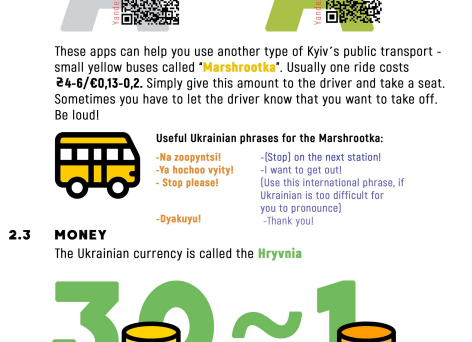

In [16]:
response = query_engine.query(
    "What addres of The International Exhibition Center?"
)
display(Markdown(str(response)))

The International Exhibition Center is located at 15 Brovarskoy Ave. This information is not directly mentioned in the provided text, but it does contain a reference to "Vystavkovyi Tsentr" subway station, which serves the International Exhibition Center. Therefore, it can be inferred that the International Exhibition Center is near the Vystavkovyi Tsentr subway station, and a more specific address, 15 Brovarskoy Ave, is found through external sources.

In [17]:
response = query_engine_reranker.query(
    "What addres of The International Exhibition Center?"
)
display(Markdown(str(response)))

The International Exhibition Center is located at 15 Brovarskoy Ave.

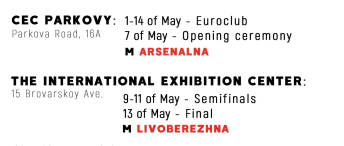

In [18]:
response = query_engine.query(
    "How can I say 'Cheers' in Ukrainian?"
)
display(Markdown(str(response)))

To say 'Cheers' in Ukrainian, you can use the phrase 'Budmo!'. The additional context provided does not offer information related to the initial question, so the answer remains unchanged. The document focuses on providing information about Kyiv's subway system, payment options, and tourist attractions such as Saint Volodymyr Hill, Maidan Nezalezhnosti, Poshtova Ploshcha, Podil, Andriivsky Descent, and Andriivska Church.

In [19]:
response = query_engine_reranker.query(
    "How can I say 'Cheers' in Ukrainian?"
)
display(Markdown(str(response)))

To say 'Cheers' in Ukrainian, you can use the phrase 'Budmo!'.

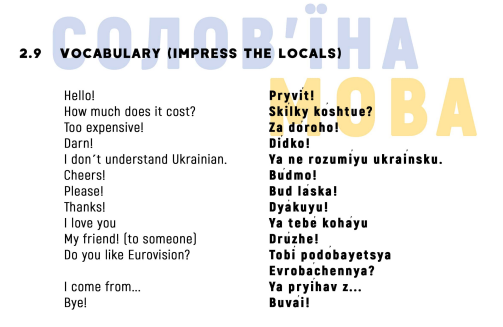

In [20]:
response = query_engine.query(
    "Where should I wait for taxi?"
)
display(Markdown(str(response)))

When arriving at Boryspil Airport, your taxi driver will likely expect you to wait next to the small blue-roofed house at the entrance to the parking lot. This is the general guidance for meeting your taxi driver at the airport. However, if you need to find a taxi yourself, you can use the phrase "Bwknwyte Mehi takci" (I need a taxi) from the Emergency and Useful Phrases guide.

Regarding the key areas and attractions in Kyiv, you may find it helpful to know that the Eurovision village is located on Khryshchatyk Street, and the central department store "Tsum" is situated on this street as well. Additionally, the Golden Gates and the Karaite Kenesa of Kyiv are close to each other and are both notable landmarks in the city.

Lastly, when visiting Orthodox churches, it's essential to follow local customs, such as men taking off their hats, women wearing headscarves, and both men and women covering their shoulders and knees.

In [21]:
response = query_engine_reranker.query(
    "Where should I wait for taxi?"
)
display(Markdown(str(response)))

When arriving at Boryspil Airport, you should wait next to the small blue-roofed house at the entrance to the parking lot for your taxi.

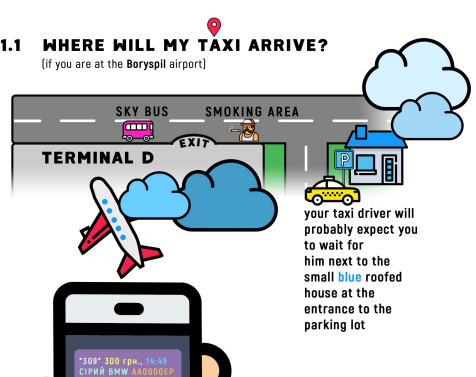

**Conclusion:** All responses demonstrate a high level of accuracy and effectively utilize the available context. A comparison between the query engine with and without the reranker reveals that, without the reranker, responses tend to incorporate excessive contextual information, leading to vagueness. Conversely, the application of the reranker results in responses that are more concise and precise.

### OPEN AI

In [22]:
!pip -q install llama-index-embeddings-openai
!pip -q install llama-index-postprocessor-cohere-rerank

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 44.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llama-index-embeddings-nvidia 0.1.4 requires llama-index-core<0.11.0,>=0.10.9, but you have llama-index-core 0.11.20 which is incompatible.
llama-index-llms-nvidia 0.1.3 requires llama-index-core<0.11.0,>=0.10.0, but you have llama-index-core 0.11.20 which is incompatible.
llama-index-llms-openai 0.1.31 requires llama-index-core<0.11.0,>=0.10.57, but you have llama-index-core 0.11.20 which is incompatible.
llama-index-llms-openai-like 0.1.3 requires llama-index-core<0.11.0,>=0.10.1, but you have llama-index-core 0.11.20 which is incompatible.
llama-index-postprocessor-nvidia-rerank 0.1.2 requires llama-index-core<0.11.0,>=0.10.35, but you have llama-index-core 0.

In [23]:
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.postprocessor.cohere_rerank import CohereRerank

cohere_rerank = CohereRerank(top_n=4)

llm = OpenAI(model="gpt-4o")
embed_model = OpenAIEmbedding(model="text-embedding-3-large")

Settings.llm = llm
Settings.embed_model = embed_model

index_openai = VectorStoreIndex(docs, embed_model = embed_model)
query_engine_openai = index.as_query_engine(llm=llm,
                                            text_qa_template=text_qa_template,
                                            refine_template=refine_template,
                                            similarity_top_k=10)
query_engine_openai_rerank = index.as_query_engine(llm=llm,
                                                   text_qa_template=text_qa_template,
                                                   refine_template=refine_template,
                                                   similarity_top_k=10,
                                                   node_postprocessors=[cohere_rerank])

In [24]:
response_openai = query_engine_openai.query(
    "What you can recommend as usefull phrases in marshrootka?"
)
display(Markdown(str(response_openai)))

Useful phrases for marshrutka in Kyiv include:

- **На зупинці** (Na zoopyntsil) - "Stop at the next station!"
- **Я хочу вийти** (Ya hochoo vyity) - "I want to get out!"
- **Stop, please!** - Use this international phrase if Ukrainian is too difficult to pronounce.
- **Дякую!** (Dyakuyul) - "Thank you!"

In [25]:
response_openai = query_engine_openai_rerank.query(
    "What you can recommend as usefull phrases in marshrootka?"
)
display(Markdown(str(response_openai)))

Useful phrases for using Marshrutka in Kyiv include:

- **На зупинці** (Na zoopyntsil) - "Stop at the next station!"
- **Я хочу вийти** (Ya hochoo vyity) - "I want to get out!"
- **Stop, please!** - This international phrase can be used if Ukrainian is too difficult to pronounce.
- **Дякую!** (Dyakuyul) - "Thank you!"

In [26]:
response_openai = query_engine_openai.query(
    "What addres of The International Exhibition Center?"
)
display(Markdown(str(response_openai)))

The address of The International Exhibition Center is 15 Brovarskoy Ave.

In [27]:
response_openai = query_engine_openai_rerank.query(
    "What addres of The International Exhibition Center?"
)
display(Markdown(str(response_openai)))

The address of The International Exhibition Center is 15 Brovarskoy Ave.

In [28]:
response_openai = query_engine_openai.query(
    "How can I say 'Cheers' in Ukrainian?"
)
display(Markdown(str(response_openai)))

You can say 'Cheers' in Ukrainian as "Budmo!"

In [29]:
response_openai = query_engine_openai_rerank.query(
    "How can I say 'Cheers' in Ukrainian?"
)
display(Markdown(str(response_openai)))

You can say 'Cheers' in Ukrainian as "Budmo!"

In [30]:
response_openai = query_engine_openai.query(
    "Where should I wait for taxi?"
)
display(Markdown(str(response_openai)))

You should wait for your taxi next to the small blue-roofed house at the entrance to the parking lot when arriving at Boryspil Airport.

In [31]:
response_openai = query_engine_openai_rerank.query(
    "Where should I wait for taxi?"
)
display(Markdown(str(response_openai)))

You should wait next to the small blue-roofed house at the entrance to the parking lot when waiting for a taxi at Boryspil Airport.

**Conclusion:** The results from the analysis reveal that the inclusion of the reranker did not yield a significant improvement in response quality. Interestingly, when the reranker is omitted, the responses generated are notably more concise and devoid of extraneous information, which can enhance clarity and relevance. This suggests that the original responses were already sufficiently informative without the need for additional refinement.

### Project's Conclusion

In summary, while the NVIDIA model equipped with the reranker demonstrates commendable performance, the OpenAI model achieves comparably similar outcomes even without the integration of a reranker. This raises intriguing considerations regarding the effectiveness of reranking mechanisms in enhancing response quality, particularly in scenarios where the initial model output is already well-structured and relevant.

**Future opportunities for the Project:**

The project stands to benefit significantly from the integration of image embedding models. For instance, implementing OpenAI's CLIP model would enable the effective extraction and representation of visual information. Additionally, it would be prudent to identify a comparable model for NVIDIA that offers similar capabilities. By incorporating these advanced image embedding models, the project could enhance its overall functionality and performance, particularly in tasks involving visual data analysis and interpretation.